Uključivanje potrebnih biblioteka i definisanje konstanti/parametara.

In [57]:
%matplotlib notebook

import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio

sample_freq = 10000

# Equalizer

In [6]:
# Parametri filtara
F_tran = 50 # Sirina prelaznih opsega filtara
num_taps = 500 # Duzina filtara
Rc = 0.1 # Maksimalno dopusteno slabljenje u propusnom opsegu u decibelima
Rp = 55 # Minimalno dozvoljeno pojacanje u nepropusnom opsegu u decibelima
deltap = 1 - 10**(-Rc/20)
deltas = 10**(-Rp/20)

# Podesivi parametri equalizera
gain1 = -12
gain2 = 15
gain3 = 12
gain4 = -9
gain5 = -15

Generisanje složenoperiodicnog signala i njegova reprodukcija.

In [76]:
n = np.arange(0,3*sample_freq,1)
F = np.array([50, 120, 260, 440, 520, 720, 1020, 1250, 1400])
compound_sig = np.zeros([n.size])
i = 0
for freq in F:
    compound_sig += np.sin(2*np.pi*freq/sample_freq * n)
compound_sig /= np.max(np.abs(compound_sig))
Audio(compound_sig, rate = sample_freq)

Pravimo EQUALIZER efekat tako što projektujemo banku od 5 filtara da pokrijemo opseg složenoperiodicnog signala. Filtri imaju sledeće granične frekvencije (u Hz): (0,299) - (300,599) - (600, 899) - (900, 1199) - (1200,1500).

In [8]:
# Prvi filtar
Fc = 299
wc = 2*Fc/sample_freq 
wp = 2*(Fc+F_tran)/sample_freq
FILTER_1 = signal.remez(num_taps,[0,wc,wp,1], [1,0], [1/deltap, 1/deltas], fs = 2)

In [9]:
# Drugi filtar
Fc1 = 300
Fc2 = 599
wp1 = 2*(Fc1-F_tran)/sample_freq
wc1 = 2*Fc1/sample_freq 
wc2 = 2*Fc2/sample_freq
wp2 = 2*(Fc2+F_tran)/sample_freq
FILTER_2 = signal.remez(num_taps,[0,wp1,wc1,wc2,wp2,1], [0,1,0],[1/deltas, 1/deltap, 1/deltas], fs = 2)

In [10]:
# Treci filtar
Fc1 = 600
Fc2 = 899
wp1 = 2*(Fc1-F_tran)/sample_freq
wc1 = 2*Fc1/sample_freq 
wc2 = 2*Fc2/sample_freq
wp2 = 2*(Fc2+F_tran)/sample_freq
FILTER_3 = signal.remez(num_taps,[0,wp1,wc1,wc2,wp2,1], [0,1,0],[1/deltas, 1/deltap, 1/deltas], fs = 2)

In [11]:
# Cetvrti filtar
Fc1 = 900
Fc2 = 1199
wp1 = 2*(Fc1-F_tran)/sample_freq
wc1 = 2*Fc1/sample_freq 
wc2 = 2*Fc2/sample_freq
wp2 = 2*(Fc2+F_tran)/sample_freq
FILTER_4 = signal.remez(num_taps,[0,wp1,wc1,wc2,wp2,1], [0,1,0],[1/deltas, 1/deltap, 1/deltas], fs = 2)

In [12]:
# Peti filtar
Fc1 = 1200
Fc2 = 1499
wp1 = 2*(Fc1-F_tran)/sample_freq
wc1 = 2*Fc1/sample_freq 
wc2 = 2*Fc2/sample_freq
wp2 = 2*(Fc2+F_tran)/sample_freq
FILTER_5 = signal.remez(num_taps,[0,wp1,wc1,wc2,wp2,1], [0,1,0],[1/deltas, 1/deltap, 1/deltas], fs = 2)

Nakon što smo projektovali filtre, izdvajamo opsege i pojačavamo specificiranim pojačanjima nakon čega dobijamo konačan signal sabiranjem signala iz izdvojenih opsega.

In [13]:
band1 = signal.lfilter(FILTER_1, 1, compound_sig) * 10**(gain1/20)
band2 = signal.lfilter(FILTER_2, 1, compound_sig) * 10**(gain2/20)
band3 = signal.lfilter(FILTER_3, 1, compound_sig) * 10**(gain3/20)
band4 = signal.lfilter(FILTER_4, 1, compound_sig) * 10**(gain4/20)
band5 = signal.lfilter(FILTER_5, 1, compound_sig) * 10**(gain5/20)
equalized_signal = band1 + band2 + band3 + band4 + band5
equalized_signal /= np.max(np.abs(equalized_signal))
Audio(equalized_signal, rate = sample_freq)
#plt.plot(equalized_signal)

Slijedi blok koda koji izvozi koeficijente filtara u header fajl za korišćenje u cross-core projektu. 

In [80]:
f = open("../test_files/equalizer.h", "w")
f.write("#define NUM_TAPS 500\n\n")
f.write("float FILTER_1[NUM_TAPS] = {\n\t")
for i in range(FILTER_1.size):
    f.write(f"{FILTER_1[i]:.7f},")
    if (i+1) % 5 == 0:
        f.write("\n\t")
f.write("\n};")
f.write("\n\n")
f.write("float FILTER_2[NUM_TAPS] = {\n\t")
for i in range(FILTER_2.size):
    f.write(f"{FILTER_2[i]:.7f},")
    if (i+1) % 5 == 0:
        f.write("\n\t")
f.write("\n};")
f.write("\n\n")
f.write("float FILTER_3[NUM_TAPS] = {\n\t")
for i in range(FILTER_3.size):
    f.write(f"{FILTER_3[i]:.7f},")
    if (i+1) % 5 == 0:
        f.write("\n\t")
f.write("\n};")
f.write("\n\n")
f.write("float FILTER_4[NUM_TAPS] = {\n\t")
for i in range(FILTER_4.size):
    f.write(f"{FILTER_4[i]:.7f},")
    if (i+1) % 5 == 0:
        f.write("\n\t")
f.write("\n};")
f.write("\n\n")
f.write("float FILTER_5[NUM_TAPS] = {\n\t")
for i in range(FILTER_5.size):
    f.write(f"{FILTER_5[i]:.7f},")
    if (i+1) % 5 == 0:
        f.write("\n\t")
f.write("\n};")
f.close()

Napisaćemo blok koda koji će da učita floating point vrijednosti koje predstavljaju neki audio zapis iz fajla specificarnog file_path varijablom i koji će potom da ih reprodukuje. Ovaj dio koda nam služi da reprodukujemo izlaze dobijene iz cross-core projekta

In [14]:
file_path = "../C/projekat/output_files/equ_signal.txt"
f = open(file_path, "r")
lines = f.readlines()
f.close()
temp = [float(line.strip()) for line in lines]
audio_signal = np.array(temp)
audio_signal /= np.max(np.abs(audio_signal))
Audio(audio_signal, rate = sample_freq)

Prikazaćemo isječke dobijenih signala (negdje oko sredine) u pythonu i sa ADSP procesora.

<IPython.core.display.Javascript object>


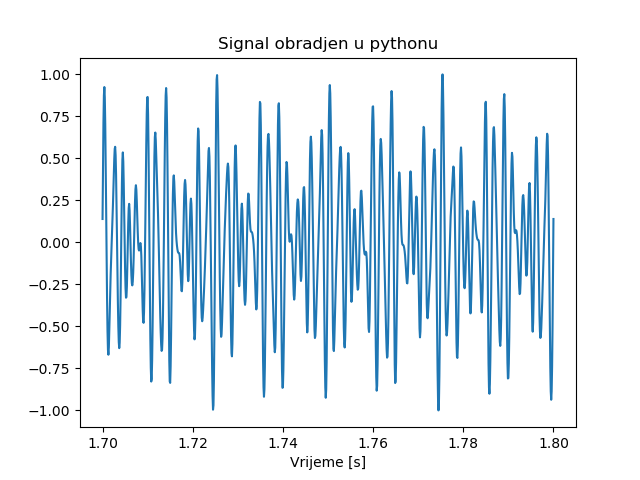

In [15]:
plt.figure()
x_axis = np.arange(1.7,1.8,0.0001)
plt.xlabel("Vrijeme [s]")
plt.title("Signal obradjen u pythonu")
plt.plot(x_axis,equalized_signal[17000:18001])

<IPython.core.display.Javascript object>


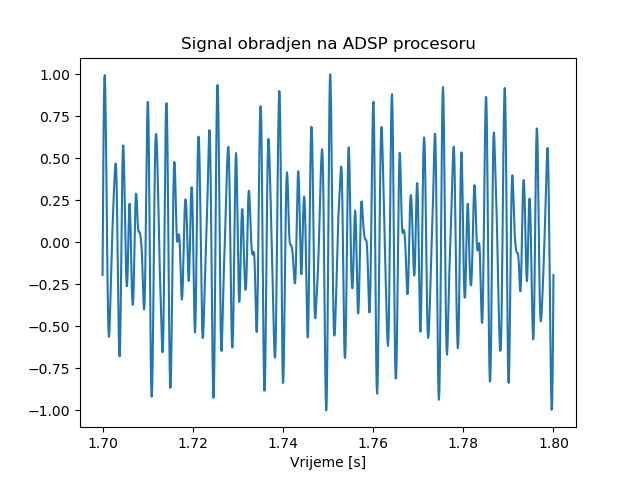

In [16]:
plt.figure()
plt.xlabel("Vrijeme [s]")
plt.title("Signal obradjen na ADSP procesoru")
plt.plot(x_axis,audio_signal[17000:18001])

Sada računamo grešku i prikazujemo na cjelokupnom trajanju.

<IPython.core.display.Javascript object>


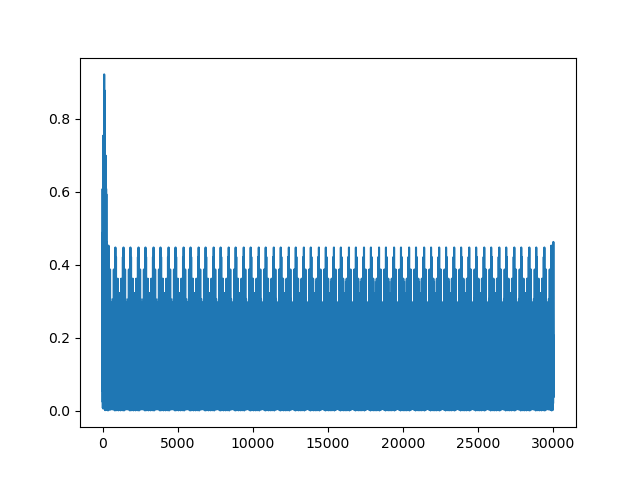

In [17]:
error = np.abs(equalized_signal - audio_signal)
plt.figure()
plt.plot(error)

# Wah-wah

In [59]:
# Parametri wah-wah filtra
F_low = 50 # Donja granicna frekvencija u Hz
F_high = 1500 # Gornja granicna frekvencija u Hz
wah = 1800 # wah frekvencija
damp = 0.1 # Faktor prigusenja

In [27]:
# Pokrenuti ovu liniju za primjenu wah-wah efekta na primjeru akusticne gitare
sample_freq, compound_sig = wavfile.read('acoustic.wav')

Nakon podešenih parametara implementiramo efekat.

In [60]:
centre_freq = wah / sample_freq
# Kreiramo LFO (niskofrekventni oscilator) u vidu trougaonog modulatora
cutoff_freq = np.arange(F_low, F_high, centre_freq)
while cutoff_freq.size < compound_sig.size:
    tmp_arr = np.arange(F_high, F_low, -centre_freq)
    cutoff_freq = np.append(cutoff_freq, tmp_arr)
    tmp_arr = np.arange(F_low, F_high, centre_freq)
    cutoff_freq = np.append(cutoff_freq, tmp_arr)
yl = np.zeros(compound_sig.size)
yb = np.zeros(compound_sig.size)
yh = np.zeros(compound_sig.size)
# Racunamo prvu iteraciju van petlje
F1 = 2*np.sin(np.pi*cutoff_freq[0]/sample_freq)
Q1 = 2*damp
yh[0] = compound_sig[0] 
yb[0] = F1*yh[0]
yl[0] = F1*yb[0]
# Izvrsavamo algoritam
for i in range(1, compound_sig.size):
    yh[i] = compound_sig[i] - yl[i-1] - Q1*yb[i-1]
    yb[i] = F1*yh[i] + yb[i-1]
    yl[i] = F1*yb[i] + yl[i-1]
    F1 = 2*np.sin(np.pi*cutoff_freq[i]/sample_freq)
# Zeljeni signal je u yb nizu
wah_signal = yb / np.max(np.abs(yb))
Audio(wah_signal, rate = sample_freq)

Prikazujemo originalni i wah signal dobijenog u pythonu.

<IPython.core.display.Javascript object>


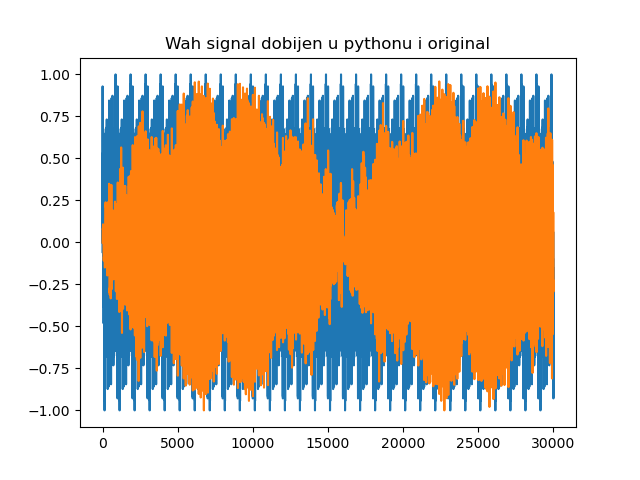

In [20]:
plt.figure()
plt.title("Wah signal dobijen u pythonu i original")
plt.plot(compound_sig)
plt.plot(wah_signal)

A sada upoređujemo original i sa wah signalom dobijenim na ADSP procesoru.

<IPython.core.display.Javascript object>


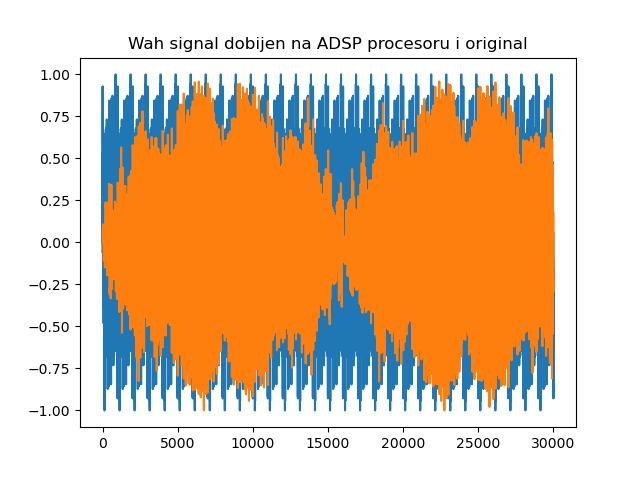

In [21]:
file_path = "../C/projekat/output_files/wah_signal.txt"
f = open(file_path, "r")
lines = f.readlines()
f.close()
temp = [float(line.strip()) for line in lines]
audio_signal = np.array(temp)
audio_signal /= np.max(np.abs(audio_signal))
plt.figure()
plt.title("Wah signal dobijen na ADSP procesoru i original")
plt.plot(compound_sig)
plt.plot(audio_signal)
Audio(audio_signal, rate = sample_freq)

Za kraj ćemo još prikazati grešku signala dobijenog u pythonu i sa ADSP procesora.

<IPython.core.display.Javascript object>


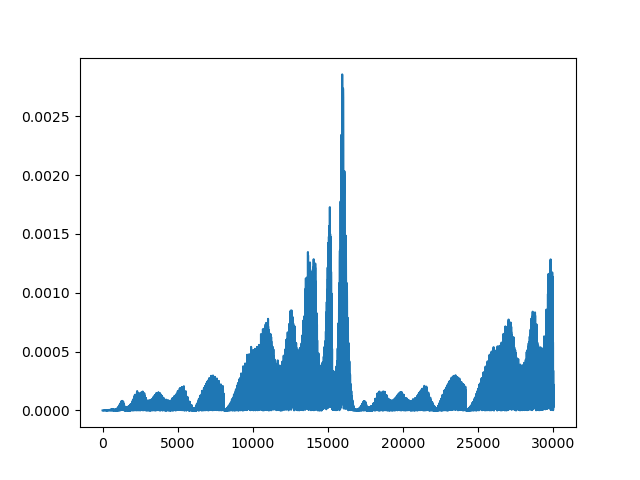

In [22]:
error = np.abs(wah_signal - audio_signal)
plt.figure()
plt.plot(error)

# Flanger

In [74]:
# Parametri flanger-a
delay = 0.0008 # Maksimalno zeljeno kasnjenje
F_osc = 8 # Frekvencija oscilatora (u Hz)

In [55]:
# Pokrenuti ovu liniju za primjenu flanger efekta na primjeru akusticne gitare
sample_freq, compound_sig = wavfile.read('acoustic.wav')

Nakon podešavanja parametara implementiramo efekat.

In [84]:
R = np.round(delay*sample_freq)  
w_osc = 2*np.pi*F_osc/sample_freq  
l = int(2*(R+1))            # ukupna duzina linije za kasnjenje
delayline = np.zeros(l)     # alokacija memorije za liniju za kasnjenje
flanged_sig = np.zeros(compound_sig.size) 
for i in range(compound_sig.size):
    beta = R*(1 + np.sin(w_osc*i))
    N = int(np.floor(beta))
    frac = beta - N
    delayline = np.concatenate(([compound_sig[i]], delayline[:l-1]))
    flanged_sig[i] = delayline[N+1]*frac + delayline[N]*(1-frac)
    flanged_sig[i] = compound_sig[i] + flanged_sig[i]
flanged_sig /= np.max(np.abs(flanged_sig))
Audio(flanged_sig, rate = sample_freq)

Sada ćemo učitati i pustiti signal dobijen obradom na ADSP procesoru.

In [85]:
file_path = "../C/projekat/output_files/flanged_signal.txt"
f = open(file_path, "r")
lines = f.readlines()
f.close()
temp = [float(line.strip()) for line in lines]
audio_signal = np.array(temp)
audio_signal /= np.max(np.abs(audio_signal))
Audio(audio_signal, rate = sample_freq)

I za kraj prikazaćemo isječke signala dobijenih u pythonu i na ADSP procesoru kao i signal greške, slično kao što smo za signal sa equalizer-a.

<IPython.core.display.Javascript object>


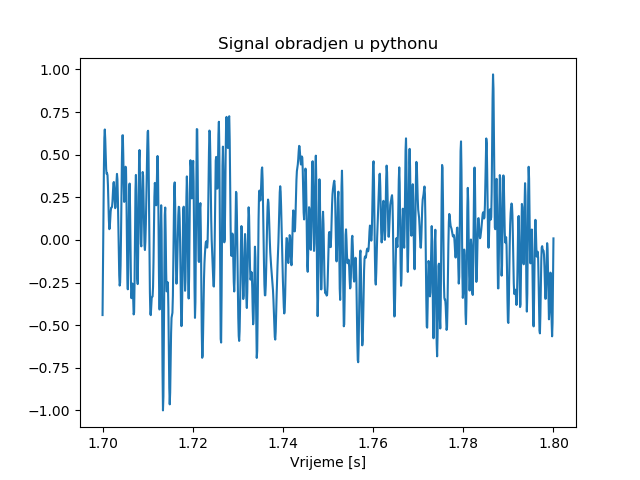

In [86]:
plt.figure()
x_axis = np.arange(1.7,1.8,0.0001)
plt.xlabel("Vrijeme [s]")
plt.title("Signal obradjen u pythonu")
plt.plot(x_axis,flanged_sig[17000:18001])

<IPython.core.display.Javascript object>


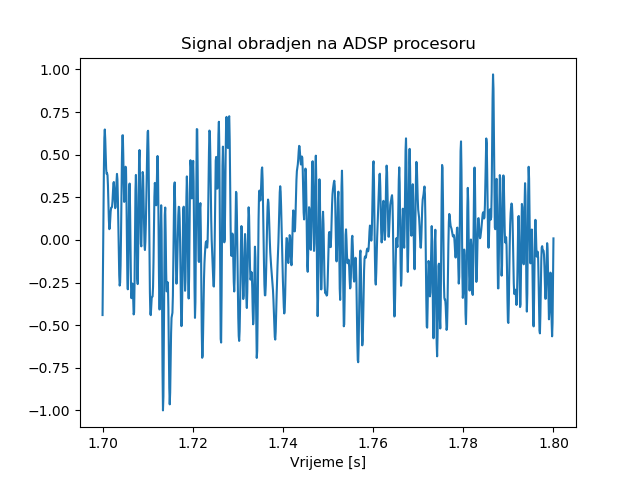

In [87]:
plt.figure()
plt.xlabel("Vrijeme [s]")
plt.title("Signal obradjen na ADSP procesoru")
plt.plot(x_axis,audio_signal[17000:18001])

<IPython.core.display.Javascript object>


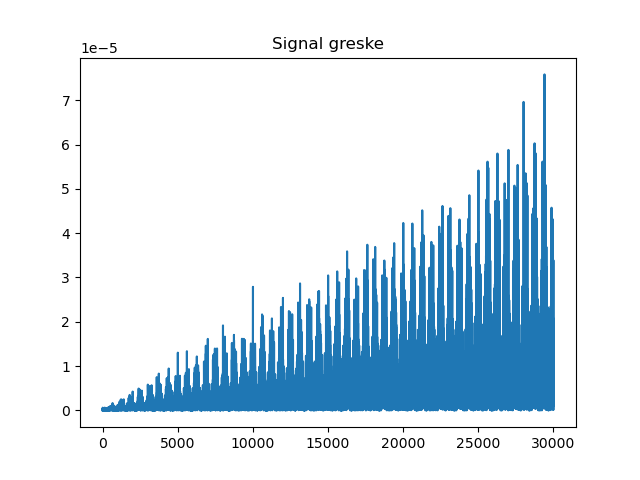

In [88]:
error = np.abs(flanged_sig - audio_signal)
plt.figure()
plt.title("Signal greske")
plt.plot(error)